In [35]:
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
conn = dict(database='test',
           host='https://clickhouse.lab.karpov.courses',
           user='student',
           password='dpo_python_2020')

In [3]:
q = "select * from test.installs limit 1000"
df = ph.read_clickhouse(q, connection=conn)
df

,InstallationDate,InstallCost,Platform,DeviceID,Source
0,2019-03-02,0,android,7950068545577019282,Source_27
1,2019-03-17,49,android,17173992779193729517,Source_14
2,2019-04-07,56,android,9528182466778893591,Source_14
3,2019-06-25,39,android,2212531864415574595,Source_9
4,2019-04-13,0,android,6959033924999748551,Source_27
...,...,...,...,...,...
995,2019-01-09,334,android,5435327797863630841,Source_14
996,2019-03-05,19,iOS,16012086443778979967,Source_9
997,2019-06-12,0,iOS,1637578224854940304,Source_27
998,2019-07-01,171,android,9176486286906828772,Source_9


In [7]:
q = """
SELECT 
    ds,
    uniqExact(DeviceID) as uniq_devices
FROM test.installs
WHERE
    Source = 'Source_27' AND
    InstallCost = 0
GROUP BY CAST(InstallationDate AS Date) as ds
ORDER BY ds ASC
"""

df = ph.read_clickhouse(q, connection=conn)
df['ds'] = pd.to_datetime(df.ds)
df

,ds,uniq_devices
0,2019-01-01,26243
1,2019-01-02,31303
2,2019-01-03,34017
3,2019-01-04,33807
4,2019-01-05,33925
...,...,...
272,2019-09-30,19028
273,2019-10-01,19176
274,2019-10-02,18926
275,2019-10-03,18373


In [11]:
q = """
SELECT 
    host_id,
    host_verifications
FROM ldn_listings
WHERE
    experiences_offered != 'none'
"""

df = ph.read_clickhouse(q, connection=conn)
df

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1543,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1544,2730552,"['email', 'phone', 'facebook', 'jumio', 'offli..."
1545,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."
1546,2730552,"['email', 'phone', 'facebook', 'jumio', 'offli..."


In [22]:
(df.host_verifications
 .apply(lambda x: x.strip('[]').replace("'",'').split(', '))
 .explode().value_counts()
)

phone                    1548
email                    1531
reviews                  1493
government_id            1373
jumio                    1279
offline_government_id     573
work_email                322
facebook                  307
selfie                    300
identity_manual           272
manual_offline             86
google                     43
kba                        29
manual_online              19
sent_id                    13
Name: host_verifications, dtype: int64

In [30]:
q = """
SELECT 
    neighbourhood_cleansed,
    experiences_offered,
    count(experiences_offered) as experiences_count

FROM ldn_listings

WHERE
    experiences_offered != 'none' 

group by 
    neighbourhood_cleansed,
    experiences_offered
    
order by experiences_count DESC
limit 100
"""
df = ph.read_clickhouse(q, connection=conn)
piv = df.pivot_table(columns='experiences_offered', index='neighbourhood_cleansed', values='experiences_count')
piv.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0


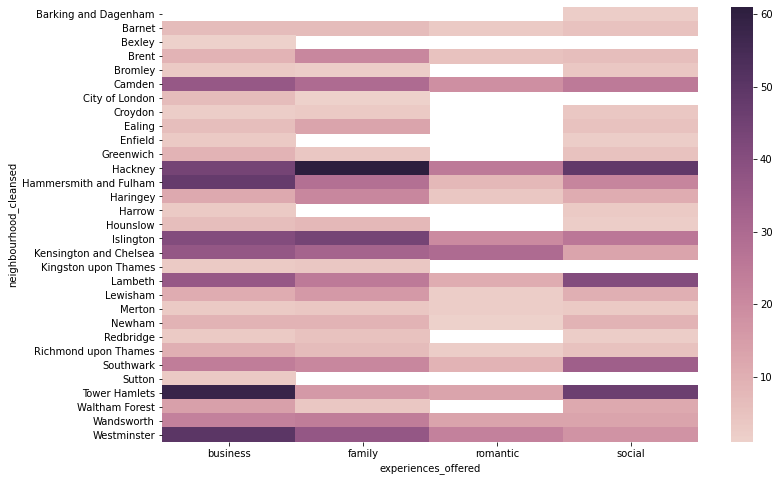

In [37]:
plt.figure(figsize=(12,8))
sns.heatmap(piv, cmap=sns.cubehelix_palette(as_cmap=True));

In [38]:
q = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) as price_corr

FROM ldn_listings

WHERE
    experiences_offered != 'none' 
"""
df = ph.read_clickhouse(q, connection=conn)
df

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


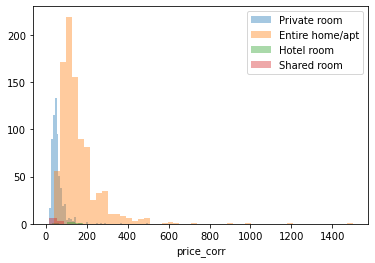

In [43]:
sns.distplot(df.query("room_type == 'Private room'").price_corr, kde=False, label='Private room')
sns.distplot(df.query("room_type == 'Entire home/apt'").price_corr, kde=False, label='Entire home/apt')
sns.distplot(df.query("room_type == 'Hotel room'").price_corr, kde=False, label='Hotel room')
sns.distplot(df.query("room_type == 'Shared room'").price_corr, kde=False, label='Shared room')
plt.legend();

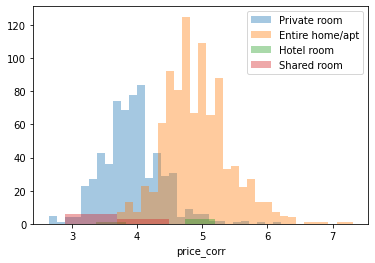

In [45]:
sns.distplot(np.log(df.query("room_type == 'Private room'").price_corr), kde=False, label='Private room')
sns.distplot(np.log(df.query("room_type == 'Entire home/apt'").price_corr), kde=False, label='Entire home/apt')
sns.distplot(np.log(df.query("room_type == 'Hotel room'").price_corr), kde=False, label='Hotel room')
sns.distplot(np.log(df.query("room_type == 'Shared room'").price_corr), kde=False, label='Shared room')
plt.legend();